### Visualizes samples from Panoptic Narrative Grounding benchmark on MSCOCO

In [1]:
%load_ext autoreload
%autoreload 2

In [113]:
import os
from os.path import join, isdir, exists

from PIL import Image
from skimage import io
import numpy as np
import textwrap
import matplotlib.pyplot as plt
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [3]:
os.chdir("../")

In [135]:
from clip_grounding.utils.paths import REPO_PATH, DATASET_ROOTS
from clip_grounding.utils.io import load_json
from clip_grounding.utils.visualize import show_single_image, set_latex_fonts, show_grid_of_images, COLORS

In [5]:
# set_latex_fonts(show_sample=True)

### Set paths

In [6]:
REPO_PATH

'/Users/piyush/projects/CLIP-grounding'

In [7]:
PNG_ROOT = DATASET_ROOTS["PNG"]

In [8]:
PNG_ROOT

'/Users/piyush/projects/CLIP-grounding/data/panoptic_narrative_grounding'

In [9]:
assert isdir(PNG_ROOT)

In [10]:
!ls $PNG_ROOT/

__MACOSX    annotations features    images


### Load annotations for `val` set

In [11]:
split = "val2017"
ann_dir = join(PNG_ROOT, "annotations")
feat_dir = join(PNG_ROOT, "features")

In [12]:
panoptic = load_json(join(ann_dir, "panoptic_{:s}.json".format(split)))
images = panoptic["images"]
images = {i["id"]: i for i in images}
panoptic_anns = panoptic["annotations"]
panoptic_anns = {int(a["image_id"]): a for a in panoptic_anns}

In [13]:
panoptic_pred_path = join(
    feat_dir, split, "panoptic_seg_predictions"
)
assert isdir(panoptic_pred_path)

In [15]:
panoptic_narratives_path = join(PNG_ROOT, "annotations", f"png_coco_{split}.json")
panoptic_narratives = load_json(panoptic_narratives_path)

In [32]:
# png_processed_annotations_path = join(PNG_ROOT, "annotations", f"png_coco_{phase}_dataloader.json")
# png_processed_annotations = load_json(png_processed_annotations_path)

### Visualize an example

In [16]:
idx = 100

narr = panoptic_narratives[idx]

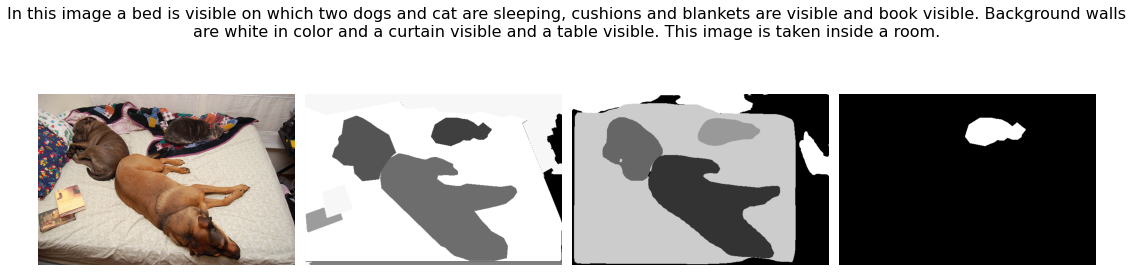

In [18]:
image_id = narr["image_id"]
image_path = join(PNG_ROOT, "images", split, f"{image_id.zfill(12)}.jpg")
assert exists(image_path)

image = Image.open(image_path)
caption = narr["caption"]

# show_single_image(image, title=caption, titlesize=12)

segments = narr["segments"]

image_id = int(narr["image_id"])
panoptic_ann = panoptic_anns[image_id]
panoptic_ann = panoptic_anns[image_id]
segment_infos = {}
for s in panoptic_ann["segments_info"]:
    idi = s["id"]
    segment_infos[idi] = s

    
image_info = images[image_id]
panoptic_segm = io.imread(
    join(
        ann_dir,
        "panoptic_segmentation",
        split,
        "{:012d}.png".format(image_id),
    )
)
panoptic_segm = (
    panoptic_segm[:, :, 0]
    + panoptic_segm[:, :, 1] * 256
    + panoptic_segm[:, :, 2] * 256 ** 2
)

panoptic_ann = panoptic_anns[image_id]

panoptic_pred = io.imread(
    join(panoptic_pred_path, "{:012d}.png".format(image_id))
)[:, :, 0]


# select a single utterance to visualize
segment = segments[7]
segment_ids = segment["segment_ids"]
segment_mask = np.zeros((image_info["height"], image_info["width"]))
for segment_id in segment_ids:
    segment_id = int(segment_id)
    segment_mask[panoptic_segm == segment_id] = 1.


show_grid_of_images(
    images=[image, Image.fromarray(panoptic_segm), panoptic_pred, segment_mask],
    n_cols=4,
    title=textwrap.fill(caption, 140),
    figsize=(15, 7),
    titlesize=16,
)


In [97]:
segment

{'utterance': 'cat', 'segment_ids': ['2501434'], 'plural': False, 'noun': True}

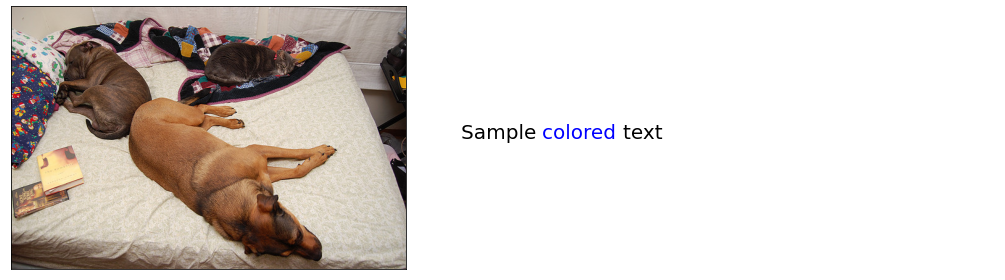

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

ax = axes[0]
ax.imshow(image)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1]
text = textwrap.fill(caption, 30)
# ax.text(
#     0., 0.5, r"Sample text with color",
#     horizontalalignment='left',
#     verticalalignment='center',
#     transform=ax.transAxes,
#     clip_on=True,
#     fontsize=25,
# )
rainbow_text(
    0., 0.5,
    ["Sample", "colored", "text"],
    ['black', "blue", "black"],
    size=20, ax=ax, fig=fig,
)
ax.axis("off")

fig.tight_layout()

plt.show()

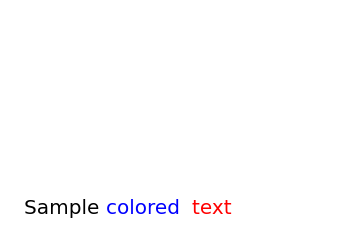

In [72]:
import matplotlib.pyplot as plt
from matplotlib import transforms

def rainbow_text(x,y,ls,lc,fig, ax,**kw):
    """
    Take a list of strings ``ls`` and colors ``lc`` and place them next to each
    other, with text ls[i] being shown in color lc[i].
    
    Ref: https://stackoverflow.com/questions/9169052/partial-coloring-of-text-in-matplotlib
    """
    t = ax.transAxes

    for s,c in zip(ls,lc):
        
        text = ax.text(x,y,s+" ",color=c, transform=t, **kw)
        text.draw(fig.canvas.get_renderer())
        ex = text.get_window_extent()
        t = transforms.offset_copy(text._transform, x=ex.width, units='dots')


fig, ax = plt.subplots(1, 1,)
rainbow_text(
    0.05,0.05,
    ["Sample", "colored", "\n", "text"],
    ['black', "blue", "black", "red"],
    size=20, ax=ax, fig=fig,
    multialignment="center",
)
ax.axis("off")
plt.show()

# rainbow_text(0.05,0.05,"all unicorns poop rainbows ! ! !".split(), 
#         ['red', 'orange', 'brown', 'green', 'blue', 'purple', 'black'],
#         size=20, fig=fig, ax=ax)

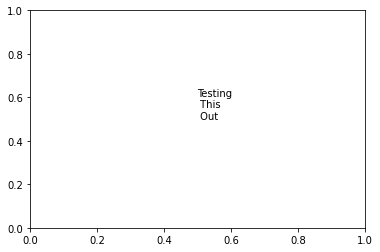

In [69]:
# plt.annotate('Testing\nThis\nOut', xy=(0.5, 0.5))
plt.text(s='Testing \n This \n Out', x=0.5, y=0.5)

plt.show()


In [102]:
def find_first_index_greater_than(elements, key):
    return next(x[0] for x in enumerate(elements) if x[1] > key)


def split_caption_phrases(caption_phrases, colors, max_char_in_a_line=50):
    char_lengths = np.cumsum([len(x) for x in caption_phrases])
    thresholds = [max_char_in_a_line * i for i in range(1, 1 + char_lengths[-1] // max_char_in_a_line)]

    utt_per_line = []
    col_per_line = []
    start_index = 0
    for t in thresholds:
        index = find_first_index_greater_than(char_lengths, t)
        utt_per_line.append(caption_phrases[start_index:index])
        col_per_line.append(colors[start_index:index])
        start_index = index

    return utt_per_line, col_per_line


def show_image_and_caption(image: Image, caption_phrases: list, colors: list = None):

    if colors is None:
        colors = ["black" for _ in range(len(caption_phrases))]

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))

    ax = axes[0]
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[1]
    utt_per_line, col_per_line = split_caption_phrases(caption_phrases, colors, max_char_in_a_line=50)
    y = 0.7
    for U, C in zip(utt_per_line, col_per_line):
        rainbow_text(
            0., y,
            U,
            C,
            size=15, ax=ax, fig=fig,
            horizontalalignment='left',
            verticalalignment='center',
        )
        y -= 0.11

    ax.axis("off")

    fig.tight_layout()
    plt.show()

In [103]:
utterances

['In this',
 'image',
 'a',
 'bed',
 'is visible on which',
 'two dogs',
 'and',
 'cat',
 'are sleeping,',
 'cushions',
 'and',
 'blankets',
 'are visible and',
 'book',
 'visible.',
 'background walls',
 'are white in',
 'color',
 'and a',
 'curtain',
 'visible and a',
 'table',
 'visible. this',
 'image',
 'is taken inside a',
 'room',
 '.']

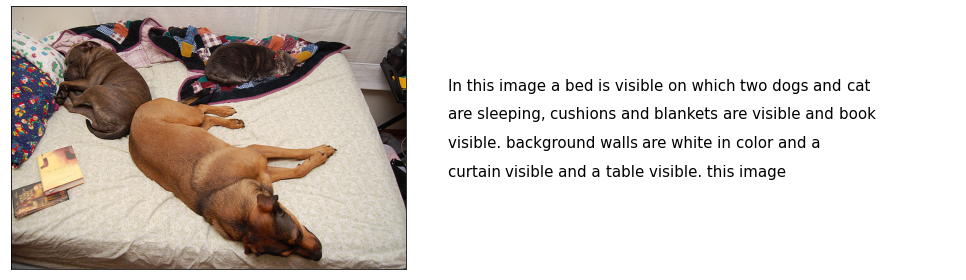

In [105]:
colors = ["black" for _ in range(len(utterances))]
# colors[7] = "red"

show_image_and_caption(image, utterances, colors)

In [141]:
segmap = SegmentationMapsOnImage(segment_mask.astype(np.uint8), shape=segment_mask.shape)
image_with_segmap = Image.fromarray(segmap.draw_on_image(np.asarray(image), colors=[0, COLORS["green"]])[0])

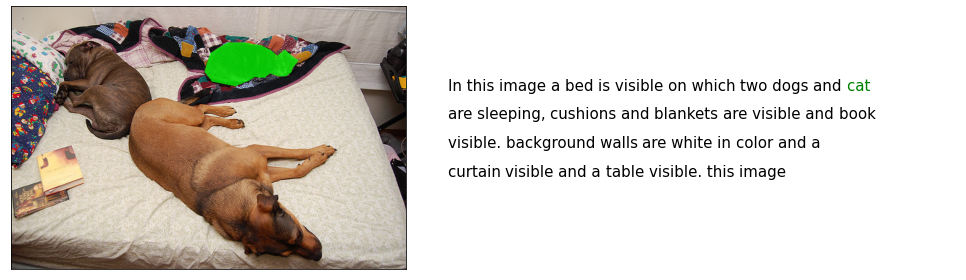

In [143]:
colors = ["black" for _ in range(len(utterances))]
colors[7] = "green"

show_image_and_caption(image_with_segmap, utterances, colors)

In [88]:
utterances = [s["utterance"] for s in segments]
utterances[0] = utterances[0].capitalize()
char_length = np.cumsum([len(u) for u in utterances])

default_colors = ["black" for _ in range(len(utterances))]

max_char_in_a_line = 50
thresholds = [max_char_in_a_line * i for i in range(1, 1 + char_length[-1] // max_char_in_a_line)]

def find_first_index_greater_than(elements, key):
    return next(x[0] for x in enumerate(elements) if x[1] > key)

# utterances_with_newlines = [] * (len(utterances) +)
utterances_with_newlines = []

utt_per_line = []
col_per_line = []
start_index = 0
for t in thresholds:
    index = find_first_index_greater_than(char_length, t)
    utt_per_line.append(utterances[start_index:index])
    col_per_line.append(default_colors[start_index:index])
    # utterances_with_newlines += (utterances[start_index:index] + ["\n"])
    start_index = index + 1
    
default_colors = ["black" for _ in range(len(utterances_with_newlines))]

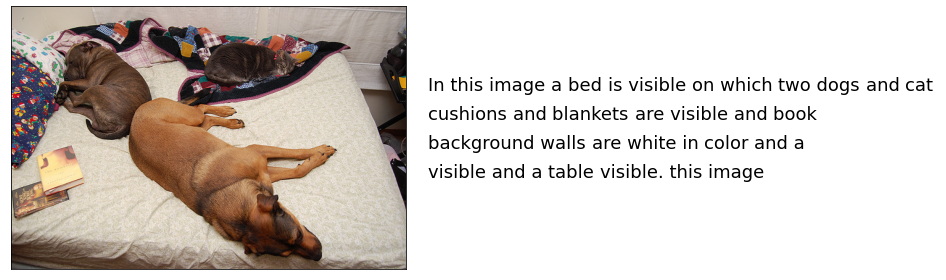

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

ax = axes[0]
ax.imshow(image)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1]
text = textwrap.fill(caption, 30)
# ax.text(
#     0., 0.5, r"Sample text with color",
#     horizontalalignment='left',
#     verticalalignment='center',
#     transform=ax.transAxes,
#     clip_on=True,
#     fontsize=25,
# )
rainbow_text(
    0., 0.5,
    utterances_with_newlines,
    default_colors,
    size=20, ax=ax, fig=fig,
    horizontalalignment='left',
    verticalalignment='center',
)

y = 0.7
for U, C in zip(utt_per_line, col_per_line):
    rainbow_text(
        0., y,
        U,
        C,
        size=18, ax=ax, fig=fig,
        horizontalalignment='left',
        verticalalignment='center',
    )
    y -= 0.11

ax.axis("off")

fig.tight_layout()

plt.show()

In [55]:
text

'In this image a bed is visible\non which two dogs and cat are\nsleeping, cushions and\nblankets are visible and book\nvisible. Background walls are\nwhite in color and a curtain\nvisible and a table visible.\nThis image is taken inside a\nroom.'

In [54]:
utterances_with_newlines

['in this',
 'image',
 'a',
 'bed',
 'is visible on which',
 'two dogs',
 'and',
 'cat',
 '\\n',
 'cushions',
 'and',
 'blankets',
 'are visible and',
 'book',
 '\\n',
 'background walls',
 'are white in',
 'color',
 'and a',
 '\\n',
 'visible and a',
 'table',
 'visible. this',
 'image',
 '\\n']

In [ ]:
for i, segment in enumerate(segments):

In [91]:
segment_id

'2501434'

In [92]:
np.where(panoptic_segm == int(segment_id))

(array([ 59,  59,  59, ..., 129, 129, 129]),
 array([350, 351, 352, ..., 362, 363, 364]))

In [87]:
np.unique(segment_mask)

array([0.])

In [80]:
segment = segments[7]

In [81]:
segment

{'utterance': 'cat', 'segment_ids': ['2501434'], 'plural': False, 'noun': True}

In [82]:
segment["segment_ids"]

['2501434']

In [83]:
np.unique(panoptic_segm)

array([       0,  2501434,  3359067,  4350349,  5069678,  6191258,
        9805224,  9815269, 10134704], dtype=uint32)

In [76]:
np.unique(panoptic_pred)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [74]:
panoptic_pred.shape

(426, 640)

In [72]:
panoptic_ann.keys()

dict_keys(['segments_info', 'file_name', 'image_id'])

In [68]:
panoptic_segm.shape

(426, 640)

In [53]:
image.size

(640, 426)

In [ ]:
narr[""]

In [40]:
len(panoptic_ann)

3

In [42]:
panoptic_ann.keys()

dict_keys(['segments_info', 'file_name', 'image_id'])

In [44]:
len(panoptic_ann["segments_info"])

8

In [45]:
len(segments)

27

In [52]:
panoptic_path = join(PNG_ROOT, "annotations", f"panoptic_{phase}.json")
panoptic = load_json(panoptic_path)
images = panoptic["images"]
images = {i["id"]: i for i in images}
panoptic_anns = panoptic["annotations"]
panoptic_anns = {int(a["image_id"]): a for a in panoptic_anns}

In [53]:
len(panoptic_anns)

5000

In [55]:
panoptic_anns.keys()

dict_keys([139, 285, 632, 724, 776, 785, 802, 872, 885, 1000, 1268, 1296, 1353, 1425, 1490, 1503, 1532, 1584, 1675, 1761, 1818, 1993, 2006, 2149, 2153, 2157, 2261, 2299, 2431, 2473, 2532, 2587, 2592, 2685, 2923, 3156, 3255, 3501, 3553, 3661, 3845, 3934, 4134, 4395, 4495, 4765, 4795, 5001, 5037, 5060, 5193, 5477, 5503, 5529, 5586, 5600, 5992, 6012, 6040, 6213, 6460, 6471, 6614, 6723, 6763, 6771, 6818, 6894, 6954, 7088, 7108, 7278, 7281, 7386, 7511, 7574, 7784, 7795, 7816, 7818, 7888, 7977, 7991, 8021, 8211, 8277, 8532, 8629, 8690, 8762, 8844, 8899, 9378, 9400, 9448, 9483, 9590, 9769, 9772, 9891, 9914, 10092, 10363, 10583, 10707, 10764, 10977, 10995, 11051, 11122, 11149, 11197, 11511, 11615, 11699, 11760, 11813, 12062, 12120, 12280, 12576, 12639, 12667, 12670, 12748, 13004, 13177, 13201, 13291, 13348, 13546, 13597, 13659, 13729, 13774, 13923, 14007, 14038, 14226, 14380, 14439, 14473, 14831, 14888, 15079, 15254, 15272, 15278, 15335, 15338, 15440, 15497, 15517, 15597, 15660, 15746, 15751, 

In [56]:
panoptic_anns[int(image_id)]

{'segments_info': [{'id': 4673118,
   'category_id': 1,
   'iscrowd': 0,
   'bbox': [33, 4, 379, 625],
   'area': 116444},
  {'id': 6381410,
   'category_id': 88,
   'iscrowd': 0,
   'bbox': [16, 210, 398, 414],
   'area': 63021},
  {'id': 2500134,
   'category_id': 199,
   'iscrowd': 0,
   'bbox': [0, 0, 457, 640],
   'area': 107065}],
 'file_name': '000000322944.png',
 'image_id': 322944}

In [45]:
len(seg_annotations)

5

In [46]:
seg_annotations.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [77]:
len(seg_annotations["categories"])

133

In [82]:
categories = {x["id"]: x["name"] for x in seg_annotations["categories"]}

In [47]:
seg_annotations["images"][0]

{'license': 4,
 'file_name': '000000397133.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
 'height': 427,
 'width': 640,
 'date_captured': '2013-11-14 17:02:52',
 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
 'id': 397133}

In [49]:
seg_annotations["info"]

{'description': 'COCO 2018 Panoptic Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2018,
 'contributor': 'https://arxiv.org/abs/1801.00868',
 'date_created': '2018-06-01 00:00:00.0'}

In [23]:
len(png_annotations)

8573

In [89]:
image_id

'322944'

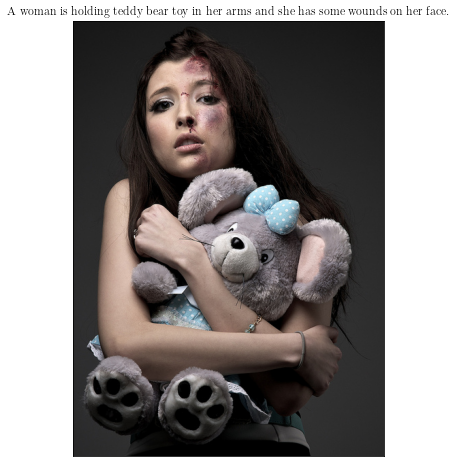

Categories present:  ['kite', 'microwave', 'bridge']
Categories present:  ['person', 'bicycle']


In [99]:
idx = 100

item = png_annotations[idx]

image_id = item["image_id"]
image_path = join(PNG_ROOT, "images", phase, f"{image_id.zfill(12)}.jpg")
assert exists(image_path)

image = Image.open(image_path)
caption = item["caption"]
show_single_image(image, title=caption, titlesize=12)

segment_idx = 3
segment = item["segments"][segment_idx]

# get panoptic annotations for this image
panoptic_ann = panoptic_anns[int(image_id)]

panoptic_segm = io.imread(join(PNG_ROOT, "annotations/panoptic_segmentation", phase, f"{image_id.zfill(12)}.png".format()))
categories_present = np.unique(panoptic_segm)
print("Categories present: ", [categories[c] for c in categories_present if c in categories])

panoptic_pred = io.imread(join(PNG_ROOT, "features", phase, "panoptic_seg_predictions", f"{image_id.zfill(12)}.png"))[:, :, 0]
categories_present = np.unique(panoptic_pred)
print("Categories present: ", [categories[c] for c in categories_present if c in categories])

In [93]:
np.unique(panoptic_pred)

array([0, 1, 2], dtype=uint8)

In [97]:
panoptic_pred.shape

(640, 457)

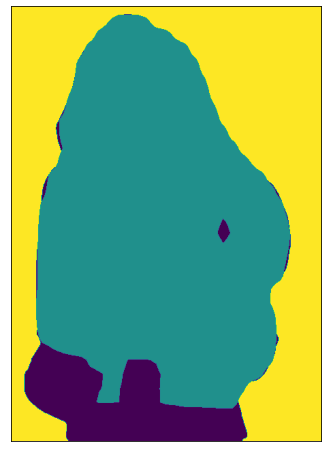

In [98]:
show_single_image(panoptic_pred)

In [58]:
panoptic_ann

{'segments_info': [{'id': 4673118,
   'category_id': 1,
   'iscrowd': 0,
   'bbox': [33, 4, 379, 625],
   'area': 116444},
  {'id': 6381410,
   'category_id': 88,
   'iscrowd': 0,
   'bbox': [16, 210, 398, 414],
   'area': 63021},
  {'id': 2500134,
   'category_id': 199,
   'iscrowd': 0,
   'bbox': [0, 0, 457, 640],
   'area': 107065}],
 'file_name': '000000322944.png',
 'image_id': 322944}

In [43]:
segment

{'utterance': 'teddy bear toy',
 'segment_ids': ['6381410'],
 'plural': False,
 'noun': True}

In [25]:
png_annotations[0]

{'image_id': '322944',
 'annotator_id': 38,
 'caption': 'A woman is holding teddy bear toy in her arms and she has some wounds on her face.',
 'segments': [{'utterance': 'a',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'woman',
   'segment_ids': ['4673118'],
   'plural': False,
   'noun': True},
  {'utterance': 'is holding',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'teddy bear toy',
   'segment_ids': ['6381410'],
   'plural': False,
   'noun': True},
  {'utterance': 'in her', 'segment_ids': [], 'plural': False, 'noun': False},
  {'utterance': 'arms', 'segment_ids': [], 'plural': True, 'noun': True},
  {'utterance': 'and she has some',
   'segment_ids': [],
   'plural': False,
   'noun': False},
  {'utterance': 'wounds', 'segment_ids': [], 'plural': True, 'noun': True},
  {'utterance': 'on her', 'segment_ids': [], 'plural': False, 'noun': False},
  {'utterance': 'face',
   'segment_ids': ['4673118'],
   'plural': False

[{'utterance': 'a', 'segment_ids': [], 'plural': False, 'noun': False},
 {'utterance': 'woman',
  'segment_ids': ['4673118'],
  'plural': False,
  'noun': True},
 {'utterance': 'is holding',
  'segment_ids': [],
  'plural': False,
  'noun': False},
 {'utterance': 'teddy bear toy',
  'segment_ids': ['6381410'],
  'plural': False,
  'noun': True},
 {'utterance': 'in her', 'segment_ids': [], 'plural': False, 'noun': False},
 {'utterance': 'arms', 'segment_ids': [], 'plural': True, 'noun': True},
 {'utterance': 'and she has some',
  'segment_ids': [],
  'plural': False,
  'noun': False},
 {'utterance': 'wounds', 'segment_ids': [], 'plural': True, 'noun': True},
 {'utterance': 'on her', 'segment_ids': [], 'plural': False, 'noun': False},
 {'utterance': 'face',
  'segment_ids': ['4673118'],
  'plural': False,
  'noun': True},
 {'utterance': '.', 'segment_ids': [], 'plural': False, 'noun': False}]

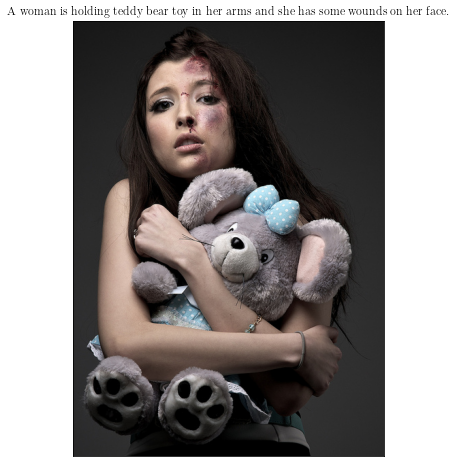